In [190]:
import pandas as pd
import numpy as np
import pyecharts
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm
#读取到的数据是丁香园截至北京时间2020/4/11 19：44的疫情累计数据，每次统计间隔大约半小时
data = pd.read_csv('./global.csv').iloc[:,:12]

In [191]:
data.head()

,continentName,continentEnglishName,countryName,countryEnglishName,provinceName,provinceEnglishName,province_zipCode,province_confirmedCount,province_suspectedCount,province_curedCount,province_deadCount,updateTime
0,北美洲,North America,美国,United States of America,美国,United States of America,971002,501615,0.0,29191,18777,2020-04-11 19:44:32
1,欧洲,Europe,意大利,Italy,意大利,Italy,965008,148217,0.0,30455,18849,2020-04-11 19:44:32
2,欧洲,Europe,西班牙,Spain,西班牙,Spain,965015,161852,0.0,59109,16353,2020-04-11 19:44:32
3,欧洲,Europe,英国,United Kingdom,英国,United Kingdom,961007,73758,0.0,135,8958,2020-04-11 19:44:32
4,欧洲,Europe,德国,Germany,德国,Germany,963003,117658,0.0,57443,2544,2020-04-11 19:44:32


In [192]:
#获取美国和意大利目标字段数据
data_us = data[data['countryEnglishName']=='United States of America']
data_italy=data[data['countryEnglishName']=='Italy']
data_us = data_us[['countryEnglishName','province_confirmedCount','province_curedCount','province_deadCount','updateTime']]
data_italy = data_italy[['countryEnglishName','province_confirmedCount','province_curedCount','province_deadCount','updateTime']]

In [193]:
#描述性统计
print('查看数据信息：列名、非空个数、类型等')
print(data_us.info())
print('-'*30)
print('查看数据摘要')
print(data_us.describe())
print('-'*30)
print('查看离散数据分布')
print(data_us.describe(include=['O']))
#所有连续数据和离散数据非空，可以不用进行缺失值处理

查看数据信息：列名、非空个数、类型等
<class 'pandas.core.frame.DataFrame'>
Int64Index: 582 entries, 0 to 127936
Data columns (total 5 columns):
countryEnglishName         582 non-null object
province_confirmedCount    582 non-null int64
province_curedCount        582 non-null int64
province_deadCount         582 non-null int64
updateTime                 582 non-null object
dtypes: int64(3), object(2)
memory usage: 27.3+ KB
None
------------------------------
查看数据摘要
       province_confirmedCount  province_curedCount  province_deadCount
count               582.000000           582.000000          582.000000
mean             113371.680412          4757.056701         3067.262887
std              146832.927902          8047.460937         4859.505179
min                   5.000000             0.000000            0.000000
25%                 704.000000            10.000000           26.000000
50%               35360.000000           178.000000          473.000000
75%              188784.250000          7079

In [194]:
#由于累积确诊人数随时间单向递增，按累计确诊人数对数据升序排列
data_us.sort_values('province_confirmedCount',inplace=True)
data_italy.sort_values('province_confirmedCount',inplace=True)
#时间数据只保留month/day
def time_cut(data):
    for i in range(len(data)):
        data.iloc[i,4] = data.iloc[i,4].split(' ')[0].split('-',1)[1]
    return data
data_us=time_cut(data_us)
data_italy=time_cut(data_italy)
#对每日数据只保留累计人数最大值
data_us_agg=data_us.groupby('updateTime').agg(np.max)
data_italy_agg=data_italy.groupby('updateTime').agg(np.max)
#加入每日新增确诊人数数据
data_us_agg['daily_confirmed']=0
data_italy_agg['daily_confirmed']=0
def cal_daily(data):
    for i in range(len(data)-1):
        data.iloc[i+1,4]=data.iloc[i+1,1]-data.iloc[i,1]
    return data
data_us_agg = cal_daily(data_us_agg)
data_italy_agg=cal_daily(data_italy_agg)
data_us_agg.to_csv('./美国疫情.csv')
data_italy_agg.to_csv('./意大利疫情.csv')

In [115]:
#绘制折线图并同时标记最大点
from pyecharts import Line
day = data_us_agg.index.tolist()
confirm = data_us_agg.province_confirmedCount.tolist()
cure=data_us_agg.province_curedCount.tolist()
dead = data_us_agg.province_deadCount.tolist()
daily_confirm = data_us_agg.daily_confirmed.tolist()
line = Line('Statistics of COVID-19 in America')
line.add('confirmed',day,confirm,is_smooth=True,mark_point=["max"])
line.add('cured',day,cure,is_smooth=True,mark_point=["max"])
line.add('death',day,dead,is_smooth=True,mark_point=["max"])
line.add('daily_confirmed',day,daily_confirm,is_smooth=True,mark_point=["max"])

In [116]:
#对Italy数据做同样处理
day = data_italy_agg.index.tolist()
confirm = data_italy_agg.province_confirmedCount.tolist()
cure=data_italy_agg.province_curedCount.tolist()
dead = data_italy_agg.province_deadCount.tolist()
daily_confirm = data_italy_agg.daily_confirmed.tolist()

line = Line('Statistics of COVID-19 in Italy')
line.add('confirmed',day,confirm,is_smooth=True,mark_point=["max"])
line.add('cured',day,cure,is_smooth=True,mark_point=["max"])
line.add('death',day,dead,is_smooth=True,mark_point=["max"])
line.add('daily_confirmed',day,daily_confirm,is_smooth=True,mark_point=["max"])
#初步通过折线图可知confirm、cure、dead属于非平稳的时间序列，daily_confirm是否平稳需要统计检

In [117]:
#针对每种属性进行时间序列分析.
#由图可知confirm，cure和dead较快呈指数上升趋势，适合用指数平滑模型分析
#daily_confirm的数据有明显趋势性的同时也存在较为明显的波动性，适合用ARIMA分析
#由于2-20之前各项数据基本没有变化，对后续时间序列参考价值不大，只截取2-20之后的数据拟合
import statsmodels.api as sm
from statsmodels.graphics.api import qqplot
data_us_agg_new = data_us_agg.loc['02-20':,:]
data_us_daily = data_us_agg_new[['daily_confirmed']].reset_index(drop=True)

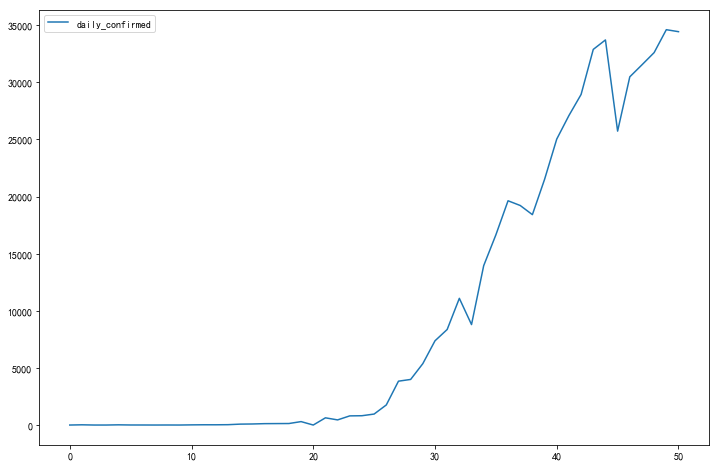

In [118]:
#数据类型转为浮点型
data_us_daily['daily_confirmed']=data_us_daily['daily_confirmed'].astype('float')
data_us_daily.plot(figsize=(12,8))

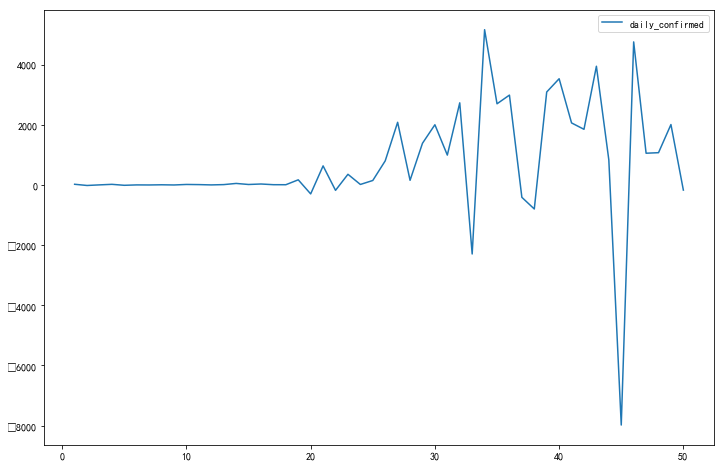

In [119]:
#1阶差分后序列已经平稳,可以考虑ARIMA模型拟合
fig = plt.figure(figsize=(12,8))
ax1= fig.add_subplot(111)
diff1 = data_us_daily.diff(1).iloc[1:,:]    #将第一行一阶差分后为NAN的数据去除
diff1.plot(ax=ax1)

C:\Users\Ricardo\Anaconda3\lib\site-packages\statsmodels\regression\linear_model.py:1283: RuntimeWarning: invalid value encountered in sqrt
  return rho, np.sqrt(sigmasq)


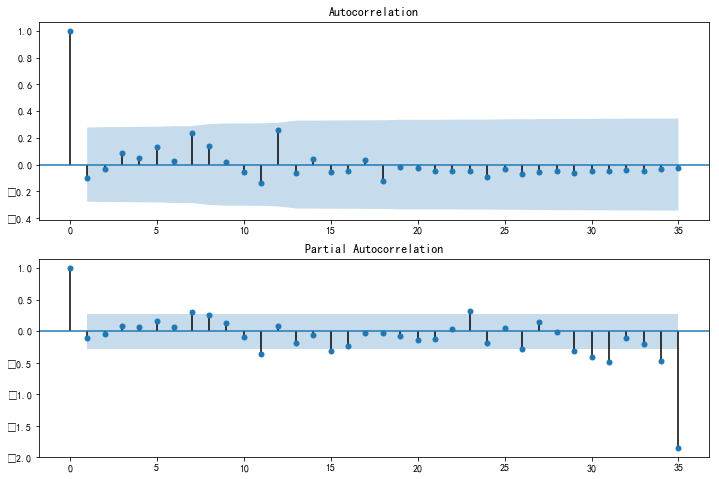

In [120]:
#参数估计，通过自相关图和偏自相关图寻找合适的p\q
fig = plt.figure(figsize=(12,8))
ax1=fig.add_subplot(211)
fig=sm.graphics.tsa.plot_acf(diff1,lags=35,ax=ax1) #35阶滞后
ax2=fig.add_subplot(212)
fig=sm.graphics.tsa.plot_pacf(diff1,lags=35,ax=ax2) #15阶滞后
#观察两图得知：自相关图1阶截尾，偏自相关图在滞后29阶后偏自相关图超出置信边界

In [121]:
#模型选择，根据上图备选模型有
#ARMA（0，1）--q=1的移动平均模型，ARMA（0,2）--q=2的移动平均模型,ARMA（1,0）--p=1的自相关模型
#根据AIC\BIC\HQ准则选取模型
arma_mod02=sm.tsa.ARMA(diff1,(0,2)).fit()
print(arma_mod02.aic,arma_mod02.bic,arma_mod02.hqic)
arma_mod01=sm.tsa.ARMA(diff1,(0,1)).fit()
print(arma_mod01.aic,arma_mod01.bic,arma_mod01.hqic)
arma_mod10=sm.tsa.ARMA(diff1,(1,0)).fit()
print(arma_mod10.aic,arma_mod10.bic,arma_mod10.hqic)
#根据AIC选择ARMA（0，2）

905.1706620343543 912.818754056067 908.0830990974619
903.1747848569566 908.9108538732411 905.3591126542873
903.2019812531221 908.9380502694065 905.3863090504527


C:\Users\Ricardo\Anaconda3\lib\site-packages\scipy\signal\signaltools.py:1341: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  out_full[ind] += zi
C:\Users\Ricardo\Anaconda3\lib\site-packages\scipy\signal\signaltools.py:1344: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  out = out_full[ind]
C:\Users\Ricardo\Anaconda3\lib\site-packages\scipy\signal\signaltools.py:1350: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as a

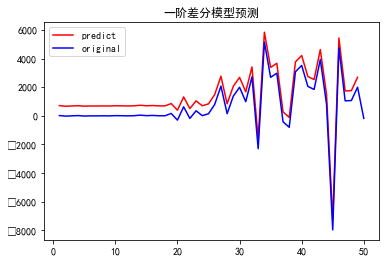

In [122]:
#模型预测
predict = arma_mod02.predict(0,53,dynamic=True)  #动态模型预测
#一阶差分还原
diff_shift_ts=diff1.shift(1)
diff_recover_1 = predict.add(diff_shift_ts['daily_confirmed'])
result=pd.DataFrame(diff_recover_1,columns=['predict'])
result['daily_confirm']=diff1
result['predict']=result['predict'].shift(-1)   #差分还原

plt.rcParams['font.sans-serif'] = 'SimHei'
plt.title('一阶差分模型预测')
result['predict'].plot(color='red',label='predict')
result['daily_confirm'].plot(color='blue',label='original')
plt.legend()
plt.show()
#模型与实际差分情况拟合度较好，可以用来预测

In [123]:
result

,predict,daily_confirm
1,718.170734,20.0
2,672.009281,-20.0
3,692.009281,0.0
4,710.009281,18.0
5,678.009281,-14.0
6,691.009281,-1.0
7,689.009281,-3.0
8,695.009281,3.0
9,689.009281,-3.0
10,706.009281,14.0


In [124]:
#根据拟合效果进一步预测之后两天数据
predict_future = pd.DataFrame(arma_mod02.predict(49,51,dynamic=True),columns=['predict'])  #动态模型预测
predict_future['predict']=predict_future['predict'].shift(-1)   #差分还原
predict_future=predict_future.iloc[:2,:]
#根据拟合结果，4-12每日确诊数比4-11多680例，4-13每日确诊数比4-12多692例

In [125]:
predict_future

,predict
50,680.379100
51,692.009281


In [126]:
predict51=predict_future.loc[50,'predict']+data_us_daily.loc[50,'daily_confirmed']
predict52=predict51+predict_future.loc[51,'predict']
predict_future.loc[50,'predict']=predict51
predict_future.loc[51,'predict']=predict52
predict_future.columns=['daily_confirmed']
outline=pd.concat([data_us_daily,predict_future],axis=0)
outline#预测结果：4-12每日确诊35111例，4-1每日确诊35803例

,daily_confirmed
0,0.00000
1,20.00000
2,0.00000
3,0.00000
4,18.00000
5,4.00000
6,3.00000
7,0.00000
8,3.00000
9,0.00000


In [127]:
#为了进行时间序列分析重新读取数据
data = pd.read_csv('./global.csv').iloc[:,:12]
data_us=data[data['countryEnglishName']=='United States of America']
data_us = data_us[['countryEnglishName','province_confirmedCount','province_curedCount','province_deadCount','updateTime']]
data_us.sort_values('province_confirmedCount',inplace=True)

#时间数据只保留year/month/day
for i in range(len(data_us)):
    data_us.iloc[i,4] = data_us.iloc[i,4].split(' ')[0]
data_us_agg=data_us.groupby('updateTime').agg(np.max)

#趋势性数据研究和预测，为了进行时间序列分析需要先将index转换成DatetimeIndex
from datetime import datetime
def str2datetime(time):
    time_list=[]
    for item in time.split('-'):
        time_list.append(int(item))
    return datetime(time_list[0],time_list[1],time_list[2])

#对每日数据只保留累计人数最大值
data_us_agg.reset_index(inplace=True)
data_us_agg.updateTime=data_us_agg.updateTime.apply(str2datetime)
data_us_agg=data_us_agg.groupby('updateTime').agg(np.max)    #还原df，索引已变为dateyimeindex

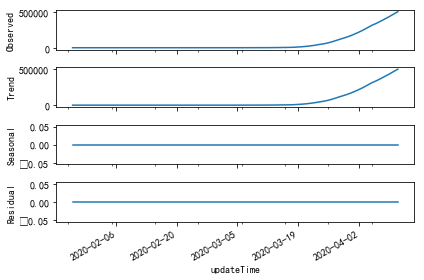

In [128]:
from statsmodels.tsa.seasonal import seasonal_decompose
us_confirm = data_us_agg[['province_confirmedCount']]
decomposition = seasonal_decompose(us_confirm,freq=1).plot()#分离趋势，指定时序序列为1否则无法找到DatetimeIndex
plt.show()
#通过时间序列季节模型提取趋势，发现累计确诊数只能提取出指数上升的趋势属性，季节属性和残差属性为0稳定，说明该指标只包括趋势属性。

In [129]:
#采用Holt指数平滑法预测未来累计确诊人数
from statsmodels.tsa.holtwinters import Holt
from sklearn.metrics import mean_squared_error
series_confirm = pd.Series(us_confirm.province_confirmedCount)

#使用Hlot线性模型预测未来10天的发展情况
def Holt_fit(series,alpha,beta):
    fit = Holt(series).fit(smoothing_level=alpha,smoothing_slope=beta,optimized=False)
    return fit.fittedvalues,fit.forecast(10)

#使用Holt指数模型预测未来10天发展情况
def Holt_exp(series,alpha,beta):
    fit = Holt(series,exponential=True).fit(smoothing_level=alpha,smoothing_slope=beta,optimized=False)
    return fit.fittedvalues,fit.forecast(10)
#模型1：水平平滑参数0.8，趋势平滑参数0.2
fitvalue1,forcast1=Holt_fit(series_confirm,0.8,0.2)
#模型2：水平平滑参数0.5，趋势平滑参数0.5
fitvalue2,forcast2=Holt_fit(series_confirm,0.5,0.5)
#模型3：水平平滑参数0.8，趋势平滑参数0.2
fitvalue3,forcast3=Holt_exp(series_confirm,0.8,0.2)
#模型4：水平平滑参数0.5，趋势平滑参数0.5
fitvalue4,forcast4=Holt_exp(series_confirm,0.5,0.5)

#通过均方根误差检查模型准确性
print('模型1RMSE：')
print(mean_squared_error(series_confirm.values,fitvalue1))
print('模型2RMSE：')
print(mean_squared_error(series_confirm.values,fitvalue2))
print('模型3RMSE：')
print(mean_squared_error(series_confirm.values,fitvalue3))
print('模型4RMSE：')
print(mean_squared_error(series_confirm.values,fitvalue4))
#从RMSE角度来看，模型1和模型2拟合效果最好

模型1RMSE：
26242752.883196533
模型2RMSE：
14768766.099985624
模型3RMSE：
87308811.37416202
模型4RMSE：
29121461.20289316


C:\Users\Ricardo\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
C:\Users\Ricardo\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:531: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  ValueWarning)
C:\Users\Ricardo\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
C:\Users\Ricardo\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:531: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  ValueWarning)
C:\U

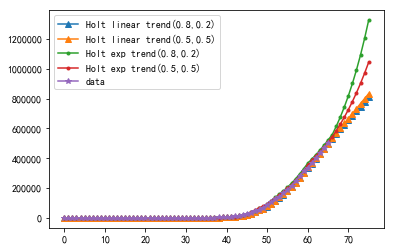

In [130]:
l1 = plt.plot(list(fitvalue1)+list(forcast1),marker='^')
l2 = plt.plot(list(fitvalue2)+list(forcast2),marker='^')
l3 = plt.plot(list(fitvalue3)+list(forcast3),marker='.')
l4 = plt.plot(list(fitvalue4)+list(forcast4),marker='.')
l5 = plt.plot(series_confirm.values,marker='*')
plt.legend(labels=['Holt linear trend(0.8,0.2)','Holt linear trend(0.5,0.5)','Holt exp trend(0.8,0.2)','Holt exp trend(0.5,0.5)','data'],loc='best')
plt.show() 

In [153]:
print(forcast1)
print(forcast2)
#模型1认为，美国累计确诊在4-12将达到531206例，4-13达到562001例，4-14达到592797例，4-21达到808367例
#模型2认为，美国累计确诊在4-12将达到532967例，4-13达到566343例，4-14达到599719例，4-21达到833354例
fit_confirm,predict_confirm=fitvalue1,forcast1

2020-04-12    22132.116574
2020-04-13    24986.084562
2020-04-14    28208.075793
2020-04-15    31845.547386
2020-04-16    35952.076128
2020-04-17    40588.147606
2020-04-18    45822.047112
2020-04-19    51730.865422
2020-04-20    58401.634277
2020-04-21    65932.608288
Freq: D, dtype: float64
2020-04-12    20416.017829
2020-04-13    22428.645842
2020-04-14    24441.273855
2020-04-15    26453.901867
2020-04-16    28466.529880
2020-04-17    30479.157893
2020-04-18    32491.785906
2020-04-19    34504.413918
2020-04-20    36517.041931
2020-04-21    38529.669944
Freq: D, dtype: float64


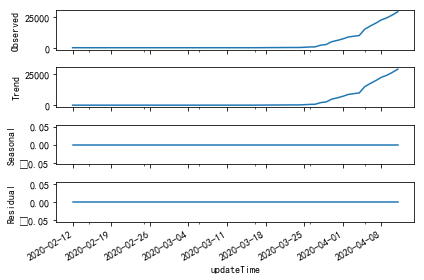

In [154]:
#累计治愈数时间序列分析
us_cure=data_us_agg[['province_curedCount']].iloc[9:,:]    #只保留统计数据非零部分
decomposition = seasonal_decompose(us_cure,freq=1).plot()#分离趋势，指定时序序列为1否则无法找到DatetimeIndex
plt.show()

In [155]:
#采用Holt指数平滑预测未来累计治愈人数
series_cure = pd.Series(us_cure.province_curedCount)

fitvalue1,forcast1=Holt_fit(series_cure,0.4,0.6)
fitvalue2,forcast2=Holt_fit(series_cure,0.3,0.7)
fitvalue3,forcast3=Holt_exp(series_cure,0.5,0.1)
fitvalue4,forcast4=Holt_exp(series_cure,0.5,0.2)

#通过均方根误差检查模型准确性
print('模型1RMSE：')
print(mean_squared_error(series_cure.values,fitvalue1))
print('模型2RMSE：')
print(mean_squared_error(series_cure.values,fitvalue2))
print('模型3RMSE：')
print(mean_squared_error(series_cure.values,fitvalue3))
print('模型4RMSE：')
print(mean_squared_error(series_cure.values,fitvalue4))
#模型1在均方根误差上表现较好

模型1RMSE：
568927.5809554635
模型2RMSE：
625209.2143018638
模型3RMSE：
11131397.329179384
模型4RMSE：
6565119.523504234


C:\Users\Ricardo\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
C:\Users\Ricardo\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:531: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  ValueWarning)
C:\Users\Ricardo\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
C:\Users\Ricardo\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:531: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  ValueWarning)
C:\U

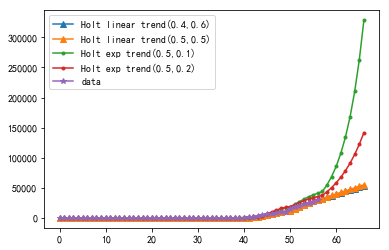

In [156]:
l1 = plt.plot(list(fitvalue1)+list(forcast1),marker='^')
l2 = plt.plot(list(fitvalue2)+list(forcast2),marker='^')
l3 = plt.plot(list(fitvalue3)+list(forcast3),marker='.')
l4 = plt.plot(list(fitvalue4)+list(forcast4),marker='.')
l5 = plt.plot(series_cure.values,marker='*')
plt.legend(labels=['Holt linear trend(0.4,0.6)','Holt linear trend(0.5,0.5)','Holt exp trend(0.5,0.1)','Holt exp trend(0.5,0.2)',
                 'data'],loc='best')
plt.show() 

In [157]:
print(forcast1)
#模型1认为，美国累计治愈在4-12将达到31874例，4-13达到34281例，4-14达到34281例，4-21达到53539例
fit_cure,predict_cure=fitvalue3,forcast3

57    31874.524527
58    34281.740961
59    36688.957394
60    39096.173828
61    41503.390261
62    43910.606695
63    46317.823128
64    48725.039562
65    51132.255995
66    53539.472429
dtype: float64


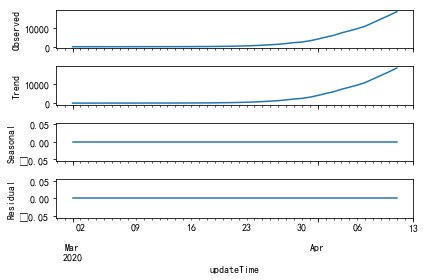

In [158]:
#累计死亡数时间序列分析
us_death=data_us_agg[['province_deadCount']].iloc[24:,:]
decomposition = seasonal_decompose(us_death,freq=1).plot()   #分离趋势
plt.show()

In [159]:
#同上，直接采用Holt指数平滑
series_dead = pd.Series(us_death.province_deadCount)
fitvalue1,forcast1=Holt_exp(series_dead,0.25,0.55)
fitvalue2,forcast2=Holt_fit(series_dead,0.4,0.6)
fitvalue3,forcast3=Holt_exp(series_dead,0.5,0.5)
print('模型1RMSE：')
print(mean_squared_error(series_dead.values,fitvalue1))
print('模型2RMSE：')
print(mean_squared_error(series_dead.values,fitvalue2))
print('模型3RMSE：')
print(mean_squared_error(series_dead.values,fitvalue3))
#根据均方根误差，模型3拟合效果较好

模型1RMSE：
167208.9275066284
模型2RMSE：
110520.52929710469
模型3RMSE：
68963.19852042208


C:\Users\Ricardo\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
C:\Users\Ricardo\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
C:\Users\Ricardo\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


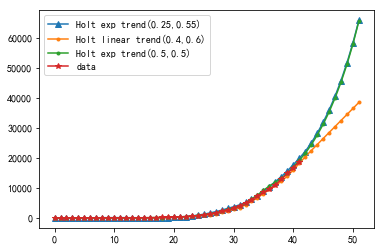

In [160]:
l1 = plt.plot(list(fitvalue1)+list(forcast1),marker='^')
l2 = plt.plot(list(fitvalue2)+list(forcast2),marker='.')
l3 = plt.plot(list(fitvalue3)+list(forcast3),marker='.')
l4 = plt.plot(series_dead.values,marker='*')
plt.legend(labels=['Holt exp trend(0.25,0.55)','Holt linear trend(0.4,0.6)','Holt exp trend(0.5,0.5)','data'],loc='best')
plt.show() 

In [161]:
print(forcast3)
#模型3认为，美国累计死亡在4-12将达到21501例，4-13达到24340例，4-14达到27555例，4-21达到 65654例
#疫情爆发初期无法控制,死亡人数野蛮增长，Holt指数模型更能从死亡人数上刻画疫情严重。
#后期随着防疫开展，疫情将逐渐得到控制，增速放缓，更适合用Holt加法模型，因此不同阶段的时间序列需要分段预测。
fit_dead,predict_dead=fitvalue3,forcast3

2020-04-12    21501.604938
2020-04-13    24340.931687
2020-04-14    27555.196790
2020-04-15    31193.911553
2020-04-16    35313.125338
2020-04-17    39976.288932
2020-04-18    45255.231913
2020-04-19    51231.269091
2020-04-20    57996.453044
2020-04-21    65654.992067
Freq: D, dtype: float64


In [162]:
#预测结果汇总输出
result=pd.DataFrame(fit_confirm,columns=['province_confirmedCount'])

fit_cure=fit_cure.values.tolist()
result['province_cureCount']=0
for i in range(len(fit_cure)):
    result.iloc[16+i:,1]=fit_cure[i]
    
fit_dead=fit_dead.values.tolist()
result['province_deadCount']=0
for i in range(len(fit_dead)):
    result.iloc[24+i:,2]=fit_dead[i]
    
forcast=pd.DataFrame(predict_dead,columns=['province_deadCount'])
forcast['province_cureCount']=0
forcast['province_confirmedCount']=0
predict_cure=predict_cure.values.tolist()
predict_confirm=predict_confirm.values.tolist()

forcast['province_cureCount']=predict_cure
forcast['province_confirmedCount']=predict_confirm
result = pd.concat([result,forcast],axis=0)

C:\Users\Ricardo\Anaconda3\lib\site-packages\ipykernel_launcher.py:22: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.



In [177]:
#最后拼接上ARIMA模型预测的每日确诊情况,由于预测数据为最近52天数据而每日确诊情况是最近53天，需要取后52项
fit_daily=outline['daily_confirmed'].values
result['province_dailyConfirm']=0
for i in range(len(fit_daily)-1):
    result.iloc[i,3]=fit_daily[i+1]

In [179]:
result.to_csv('./美国疫情预测.csv')